In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys, glob

os.chdir('/content/drive/My Drive/MaSSP/keras-yolo3')

# cd "/content/drive/My Drive/MaSSP/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from yolo import YOLO

kwargs = {
    "model_path": "model_data/yolo3-spp.h5",
    "anchors_path": "model_data/yolo_anchors.txt",
    "classes_path": "model_data/coco_classes.txt",
    "score": 0.35,
    "iou": 0.5,
    "model_image_size": (1024, 1024),
    "gpu_num": 1,
}
model = YOLO(**kwargs)
# YOLO(model_path, anchors_path, ..., gpu_num)
from yolo3.utils import letterbox_image
from keras import backend as K

class ObjDetector:
    def __init__(self):
        self.model = YOLO(
            model_path="model_data/yolo3-spp.h5",
            anchors_path="model_data/yolo_anchors.txt",
            classes_path="model_data/coco_classes.txt",
            score=0.3,
            iou=0.45,
            model_image_size=(1024, 1024),
            gpu_num=1,
        )
    
    def detect(self, image, item):
        if self.model.model_image_size != (None, None):
            assert self.model.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')
        
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.model.sess.run(
            [self.model.boxes, self.model.scores, self.model.classes],
            feed_dict={
                self.model.yolo_model.input: image_data,
                self.model.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        self.visualize(image, out_boxes, out_scores, out_classes, item)
        return out_boxes, out_scores, out_classes, item
    
    def visualize(self, image, out_boxes, out_scores, out_classes, item):
        image = np.array(image)
        for i, c in reversed(list(enumerate(out_classes))):
           if item == c+1:
              predicted_class = self.model.class_names[c]
              box = out_boxes[i]
              score = out_scores[i]

              label = '{} {:.2f}'.format(predicted_class, score)

              top, left, bottom, right = box
              top = max(0, np.floor(top + 0.5).astype('int32'))
              left = max(0, np.floor(left + 0.5).astype('int32'))
              bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
              right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))
              print(label, (left, top), (right, bottom))
              cv2.putText(image,label,(left,top), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,0),3,cv2.LINE_AA)
              cv2.rectangle(image,(left,top),(right,bottom),(0,255,0),3)
              plt.imshow(image)
              plt.show()

Using TensorFlow backend.
W0710 00:59:39.640955 140635985237888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 00:59:39.642998 140635985237888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 00:59:39.650857 140635985237888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0710 00:59:39.776749 140635985237888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0710 00:59:

model_data/yolo3-spp.h5 model, anchors, and classes loaded.


W0710 01:00:02.252464 140635985237888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
detector = ObjDetector()

would you like to take a picture or import your own? Enter take or import p
p
would you like to take a picture or import your own? Enter take or import t
t


<IPython.core.display.Javascript object>

Saved to photo.jpg


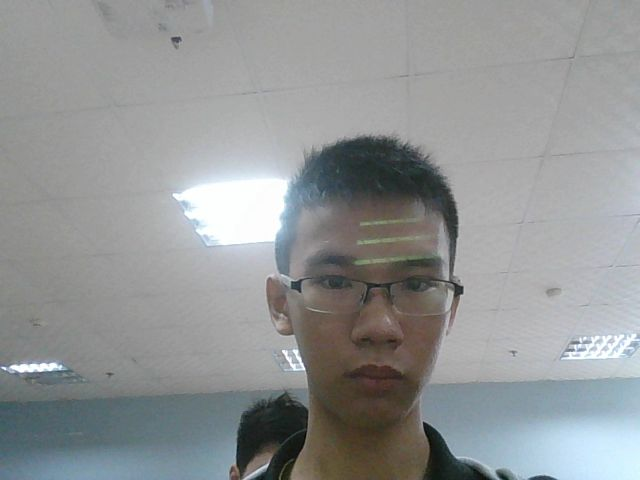

please pick an item number 1


In [27]:
from IPython.display import Image
take_pic = 'h'
while take_pic[0].lower() != 't' and take_pic[0].lower() != 'i':
  take_pic = input('would you like to take a picture or import your own? Enter take or import ')
  print(take_pic[0].lower())
if take_pic[0] == 'i':
  path = '../'+input('please enter name of your photo: ')
  from PIL import Image
  image = Image.open(path)
  item_No = int(input('please pick an item number: '))
  results = detector.detect(image, item_No)
else:
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
    from PIL import Image
    path = './photo.jpg'
    image = Image.open(path)
    item_No = int(input('please pick an item number '))
    results = detector.detect(image, item_No)
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))